## Calibration 첫 번째 논문 CCM matrix 구하기

- 진행중

In [1]:
import pandas as pd
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2

In [2]:
Thickness = pd.read_csv('./data/Thickness.csv')
Thickness = Thickness.drop([33]) # 9-1 drop
Thickness.reset_index(drop=True, inplace=True)

top_path = './data/box_img/Top/'
bot_path = './data/box_img/Bot/'

top_path_list = [f'./data/box_img/Top/Top_{i}.jpg' for i in range(0, 127)]
bot_path_list = [f'./data/box_img/Bot/Bot_{i}.jpg' for i in range(0, 127)]

In [5]:
bot_images_list = []
for path in bot_path_list:
    img = cv2.imread(path)
    bot_images_list.append(img)
    
bot_images_list = np.array(bot_images_list)
bot_images_list.shape

(127, 50, 50, 3)

In [9]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 이미지 데이터 로드
# (N, 3, 50, 50) 크기의 이미지 데이터
image_data = bot_images_list.transpose(0, 3, 1, 2)

# 이미지 데이터 reshape
num_images = image_data.shape[0]
pixel_data = image_data.reshape(num_images, -1)

Base_image = cv2.imread('./data/box_img/Bot/Bot_0.jpg')
original_data = Base_image.transpose(2, 0, 1)
original_data = original_data.reshape(-1, 3)

# 데이터 조정
pixel_data = pixel_data[:original_data.shape[0]]

# 선형 회귀 모델 학습
model = LinearRegression()
model.fit(pixel_data, original_data)

# CCM 행렬 계산
ccm_matrix = model.coef_.T


ValueError: Found input variables with inconsistent numbers of samples: [127, 2500]

In [18]:
Base_img = np.array(Image.open(top_path_list[0])) #Ref image(bot) 첫번째를 기본 이미지로 지정
Top_transformed_list = []
for i in range(len(bot_path_list)):
    bot_image = np.array(Image.open(bot_path_list[i])) #Ref image(bot) i번째를 불러옴
    top_image = np.array(Image.open(top_path_list[i])) #Top image(top) i번째를 불러옴

    inv_image = inversed_image(bot_image) #Ref image(bot) i번째를 역함수 적용
    
    Top_transformed = transform_image(top_image, inv_image) #Top image(top) i번째를 곱하여 Weighted image 생성(보정)
    Top_transformed_list.append(Top_transformed) #Weighted image를 리스트에 추가
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


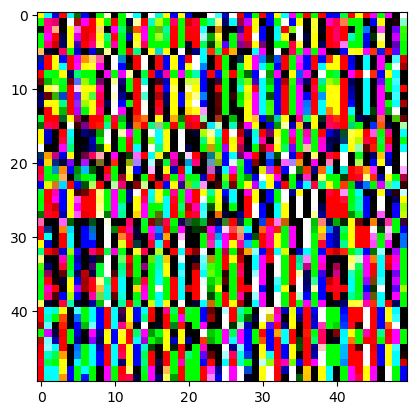

In [21]:
plt.imshow(Top_transformed_list[0])

### AutoML 먼저 시도

In [22]:
top_avg_rgb = []
for i in range(len(Top_transformed_list)):
    top = Top_transformed_list[i]
    Top_R, Top_G, Top_B = np.mean(top[:,:,0]), np.mean(top[:,:,1]), np.mean(top[:,:,2])
    
    top_avg_rgb.append([Top_R, Top_G, Top_B])

In [23]:
top_avg_rgb = np.array(top_avg_rgb)
top_avg_rgb.shape

(127, 3)

In [24]:
#top avg rgb + thickness
Table_dataset = pd.DataFrame(np.concatenate([top_avg_rgb, Thickness], axis = 1), columns=['R', 'G', 'B', 'Thickness'])
Table_dataset

,R,G,B,Thickness
0,0.013136,0.005420,0.002827,48.266667
1,0.009139,0.007558,0.005126,47.966667
2,0.018077,0.008441,0.004581,48.166667
3,0.009980,-0.002101,0.003617,48.600000
4,0.004524,0.001936,-0.000814,59.533333
...,...,...,...,...
122,0.000459,0.002730,0.016282,84.633333
123,0.002460,0.015979,0.014366,98.366667
124,-0.000139,0.004342,0.016741,97.033333
125,0.001173,0.007014,0.018004,96.266667


In [25]:
X_train, X_test, y_train, y_test = train_test_split(Table_dataset.iloc[:,:-1], Table_dataset.iloc[:,-1], test_size=0.3, random_state=42)

In [26]:
from tpot import TPOTRegressor

tpot =  TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42, cv=5, n_jobs = -1)
tpot.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -165.0281791478907

Generation 2 - Current best internal CV score: -165.0281791478907

Generation 3 - Current best internal CV score: -162.6431883980461

Generation 4 - Current best internal CV score: -160.8889637036518

Generation 5 - Current best internal CV score: -155.94777533152833

Best pipeline: AdaBoostRegressor(XGBRegressor(input_matrix, learning_rate=0.1, max_depth=2, min_child_weight=18, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.6500000000000001, verbosity=0), learning_rate=0.01, loss=exponential, n_estimators=100)


TPOTRegressor(generations=5, n_jobs=-1, population_size=50, random_state=42,
              verbosity=2)

In [27]:
y_pred = tpot.predict(X_test)
y_pred

array([ 72.50185185,  65.35686275,  72.82571429,  99.38000002,
        99.39487181,  65.45138889,  72.49555556,  90.16111111,
        59.78333333,  98.195     ,  98.35416667,  61.39444444,
       101.26190476,  61.57333333,  84.62063492, 111.27777776,
        85.23333333,  71.06805556,  67.50714286,  88.63030303,
        71.68288288, 101.26190476,  85.23111111, 153.3       ,
        54.2625    , 153.3       , 105.68730158,  99.98666669,
        72.49555556,  87.68541667,  60.56666667,  75.08611111,
        72.49555556, 111.27777776,  95.825     , 111.27777776,
        72.49555556, 153.3       ,  75.59555555])

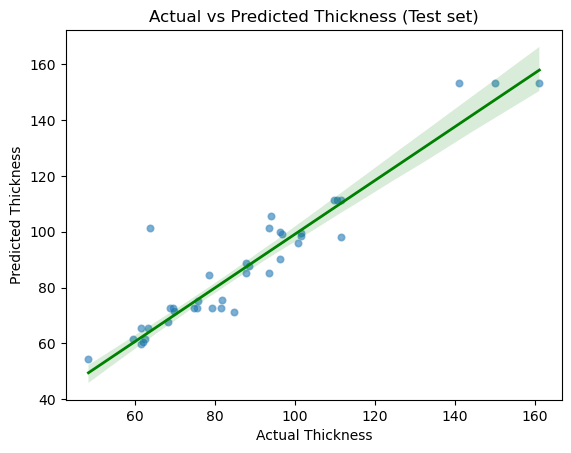

In [28]:
import statsmodels.api as sm
import seaborn as sns

# 그래프 그리기
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'green', 'linewidth': 2}, robust=True)

plt.xlabel('Actual Thickness')
plt.ylabel('Predicted Thickness')
plt.title('Actual vs Predicted Thickness (Test set)')
plt.show()

In [29]:
pd.DataFrame({'True': y_test.values, 'Predict': y_pred})

,True,Predict
0,75.533333,72.501852
1,61.300000,65.356863
2,68.700000,72.825714
3,96.633333,99.380000
4,101.466667,99.394872
5,63.166667,65.451389
6,69.433333,72.495556
7,96.266667,90.161111
8,61.466667,59.783333
9,111.533333,98.195000


In [30]:
from sklearn.metrics import mean_squared_error
# 테스트 세트에서의 RMSE 계산
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('MSE: {0:.3f}, RMSE: {1:.3f}'.format(mse, rmse))

MSE: 68.886, RMSE: 8.300
